# Pictionary Model - Can you beat the machine?


I created a model that can be used to play Pictionary. The final outcome is an application where a user can draw. As the user is drawing, a model that is hosted on AWS makes predictions to try and classify the drawing. The methodology is a combination of a Neural Network trained and deployed on AWS and a drawing application using Tkinter in Python. The model will be accessed through the use of an API, Lambda function, and Endpoint. 

The input of the model will be an array representing a 28x28 drawing of the user. Locally, the user is drawing on an application using Tkinter. Whenever the user releases the mouse, the application takes a screenshot of the drawing and converts it to an array of size 784 representing the 28x28 picture. This is then sent to the model to make the prediction. The predictions are then displayed on a different window.

**The model is trained and deployed on AWS.**


## Requirements
* Google Cloud Storage
* PyTorch
* Scikit-Learn
* SageMaker


## Author
* Saad Chaouki - sd.chaouki@gmail.com

In [ ]:
!pip install google-cloud-storage 

In [1]:
from google.cloud import storage

import os
import pandas as pd
import numpy as np
import urllib.request
import matplotlib.pyplot as plt
import random

import torch
import torchvision.models as models
import torch.utils.data
import torch.nn as nn
import torch.optim as optim

import sagemaker
from sagemaker.pytorch import PyTorchModel
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role
from sagemaker.predictor import Predictor

from collections import OrderedDict
import pickle

from sklearn.model_selection import train_test_split
from sagemaker.predictor import RealTimePredictor
from sagemaker.pytorch import PyTorchModel
from sklearn.metrics import accuracy_score

from utils.helper_functions import *

## Data Download

The first step of the project is to download the data from Google Cloud and store it locally. This will allow me to start processing it and combining multiple classes into one file. 

To achieve this, I'm using the Google Cloud package to link to the *quickdraw_dataset* bucket and download the classes that I need only. The files are stored as *npy* files that represent Numpy arrays of the images.


https://github.com/googlecreativelab/quickdraw-dataset

In [2]:
# Target folders
folder = 'data'
transformedFolder = 'data/transformed'

# Create folders
if not os.path.isdir(folder):
    os.makedirs(folder)
if not os.path.isdir(transformedFolder):
    os.makedirs(transformedFolder)

# Datasets to be downloaded.
dataset = ['bicycle.npy', 'cake.npy', 'chair.npy', 'bird.npy', 'The Mona Lisa.npy',
           'cruise ship.npy', 'airplane.npy', 'boomerang.npy', 'sock.npy', 'windmill.npy', 
           'radio.npy', 'lollipop.npy' , 'tooth.npy', 'church.npy', 'angel.npy',
           'rabbit.npy', 'pickup truck.npy', 'cell phone.npy', 'teddy-bear.npy', 'house.npy',
           'donut.npy', 'finger.npy', 'pants.npy', 'hat.npy', 'castle.npy', 'map.npy', 'car.npy',
           'cookie.npy', 'jail.npy', 'mug.npy'
          ]

# Targets
print(f'Creating the model on {len(dataset)} targets.')

Creating the model on 30 targets.


In [3]:
# Create client to download from Google Storage
prefix = 'full/numpy_bitmap'
storageClient = storage.Client.from_service_account_json('keys/googleKey.json')
bucket = storageClient.bucket(bucket_name='quickdraw_dataset')

In [4]:
# Download data from Quick Draw Dataset. Only download delta dataset.
for blob in bucket.list_blobs(prefix=prefix):
    blobName = blob.name.split('/')[-1]
    if blobName in dataset and not os.path.isfile(f"{folder}/{blobName}"):
        targetName = f"{folder}/{blobName}"
        print(f'Downloading: "{blob.name}" to {targetName}.')
        blob.download_to_filename(targetName)
print('Data Downloaded.')

Data Downloaded.


## Data Visualisation
The shape of each image is a 1D array. This is reshaped to a matrix of 28*28 before visualising it.

In [5]:
# Limit of 75000 images for each class
dataLimit = 75000

# Load all the data in a dictionary.
loadedData = {name.split('.')[0]: np.load(f'data/{name}')[:dataLimit] for name in dataset}

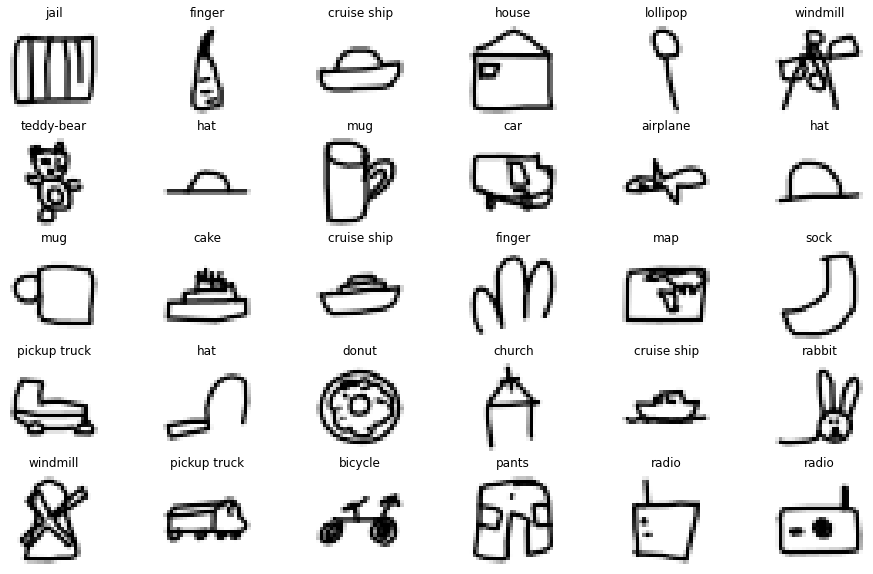

In [6]:
# Display a number of random images from the data.
displayRandomImageGrid(loadedData)

## Data Preparation

Combination of the different classes into a single array to be used as training and testing sets. The created data loaders are used for testing only and the final training and testing sets are stored on an S3 Bucket. This is because the final training will be done using a training job.

In [7]:
X = []
y = []

# Combine datasets in single array
for key, value in loadedData.items():
    X.append(value)
    y.append(np.full((len(value), 1), key).ravel())

# Cleaning 
del loadedData

# Flatten the arrays
X = np.concatenate(X, axis = 0)
y = np.concatenate(y, axis = 0)

# Size of data
print(f'Size of X list: {len(X)} - Size of y list: {len(y)}.')

Size of X list: 2250000 - Size of y list: 2250000.


In [8]:
# Zip the data then shuffle it
zippedData = list(zip(X, y))
random.shuffle(zippedData)
X, y = zip(*zippedData)

# Cleaning
del zippedData

In [9]:
# Get a dictionary of the classifications
y = pd.get_dummies(y)
dataDictionary = {index: name for index, name in enumerate(y.columns)}
y = y.values

In [10]:
def createDataLoaders(X, y, train = 0.7, val = 0.15, test = 0.15):
    indxTrain = int(len(X) * train)
    indxTest = int(len(X) * (train + val))
    # Split - Train
    X_train = X[:indxTrain]
    y_train = y[:indxTrain]
    
    # Split - Validation
    X_val = X[indxTrain: indxTest]
    y_val = y[indxTrain: indxTest]
    
    # Split - Testing
    X_test = X[indxTest:]
    y_test = y[indxTest:]
    

    # Training Loader 
    X_tensor_train = torch.from_numpy(np.array(X_train)).type(torch.FloatTensor)
    y_tensor_train = torch.from_numpy(np.array(y_train)).type(torch.FloatTensor)
    trainDataset = torch.utils.data.TensorDataset(X_tensor_train, y_tensor_train)
    trainLoader = torch.utils.data.DataLoader(trainDataset, batch_size=100)
    
    # Validation Loader 
    X_tensor_val = torch.from_numpy(np.array(X_val)).type(torch.FloatTensor)
    y_tensor_val = torch.from_numpy(np.array(y_val)).type(torch.FloatTensor)
    validationDataset = torch.utils.data.TensorDataset(X_tensor_val, y_tensor_val)
    validationLoader = torch.utils.data.DataLoader(validationDataset, batch_size=50)
    
    # Testing Loader
    X_tensor_test = torch.from_numpy(np.array(X_test)).type(torch.FloatTensor)
    y_tensor_test = torch.from_numpy(np.array(y_test)).type(torch.FloatTensor)
    testDataset = torch.utils.data.TensorDataset(X_tensor_test, y_tensor_test)
    testLoader = torch.utils.data.DataLoader(testDataset, batch_size=50)
    
    return {'train': trainLoader, 'val': validationLoader, 'test': testLoader}

In [11]:
# Only run if needed for local model training
dataLoaders = createDataLoaders(X[:100000], y[:100000])

## Upload data to S3

In [12]:
def getS3Datasets(X, y, train = .7, val = .3):
    '''
        Function to return a training and testing sets. 
    '''
    splitIndex = int(len(X) * train)
    train_X = np.array(X[:splitIndex])
    train_y = np.array(y[:splitIndex])
    val_X = np.array(X[splitIndex:])
    val_y = np.array(y[splitIndex:])
    return [train_y, train_X], [val_y, val_X]

In [13]:
trainData, valData = getS3Datasets(X, y)

In [14]:
with open(transformedFolder + "/train.txt", "wb") as f:
    pickle.dump(trainData, f)

In [15]:
with open(transformedFolder + "/val.txt", "wb") as f:
    pickle.dump(valData, f)

In [16]:
sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()
prefix = 'pictionary'
role = sagemaker.get_execution_role()

# Upload data to S3
trainingDataS3 = sagemaker_session.upload_data(path=transformedFolder + '/train.txt', bucket=bucket, key_prefix=prefix)
validationDataS3 = sagemaker_session.upload_data(path=transformedFolder +'/val.txt', bucket=bucket, key_prefix=prefix)

## Cleaning

In [17]:
del X
del y

## Model Training

In [18]:
class NeuralNetClassifier(nn.Module):
    '''
        Simple Neural Net classifier.
    '''
    def __init__(self, inputSize, hiddenSize, outputSize, dropout = 0.0):
        super(NeuralNetClassifier, self).__init__()    
            
        self.classifier = nn.Sequential(OrderedDict([
            
                      ('linear1', nn.Linear(inputSize, hiddenSize)),
                      ('relu1', nn.ReLU()),

                      ('linear2', nn.Linear(hiddenSize, hiddenSize)),
                      ('batchnorm1', nn.BatchNorm1d(num_features=hiddenSize)),
                      ('relu2', nn.ReLU()),

                      ('dropout1', nn.Dropout(dropout)),
                      
                      ('linear3', nn.Linear(hiddenSize, hiddenSize)),
                      ('relu3', nn.ReLU()),

                      ('linear4', nn.Linear(hiddenSize, hiddenSize)),
                      ('batchnorm2', nn.BatchNorm1d(num_features=hiddenSize)),
                      ('relu4', nn.ReLU()),

                      ('linear5', nn.Linear(hiddenSize, outputSize))
                      
        ])
                          )

    def forward(self, x):
        x = self.classifier(x)
        return x

In [19]:
def Evaluate(Model, DataLoader, Criterion, device):
    Model.eval()
    Model.to(device)
    EvaluationLoss = 0
    EvaluationAccuracy = 0
    for images, labels in DataLoader:
        images, labels = images.to(device), labels.to(device)
        
        Predictions = Model.forward(images)
        EvaluationLoss += Criterion(Predictions, labels).item()

        ExpPreds = torch.exp(Predictions)
        predictedClasses = ExpPreds.max(dim=1).indices.numpy()
        
        CheckPreds = (np.argmax(labels.data, axis = 1).numpy() == predictedClasses)
        EvaluationAccuracy += CheckPreds.mean()
        
    return EvaluationLoss, EvaluationAccuracy

In [20]:
def train(Model, DataLoaders, Optimizer, Criterion,  epochs = 2, gpu = True, Verbose = True):
    # Checking device
    device = torch.device("cuda" if torch.cuda.is_available() and gpu else "cpu")
    print(f"Training on {device}.")
    
    print("Initating Model Training.")
    
    # Setting the model to the device used.
    Model.to(device)
    # Training
    for epoch in range(epochs):
        # Setting the model to training mode.
        Model.train()
        running_loss = 0
        for inputs, labels in DataLoaders['train']:
            
            # Changing the  inputs to the device used.
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Setting gradients to 0
            Optimizer.zero_grad()

            # Forward and backward passes
            outputs = Model.forward(inputs)
            loss = Criterion(outputs, labels)
            loss.backward()
            Optimizer.step()
            
            # Computing Loss
            running_loss += loss.item()
            
        # Verbose
        if Verbose:
            with torch.no_grad():
                ValLoss, ValAcc = Evaluate(Model, DataLoaders['val'], Criterion, device)
            print("Epoch: {}/{}.. ".format(epoch+1, epochs),
                  "Training Loss: {:.3f}.. ".format(running_loss/len(DataLoaders['train'])),
                  "Validation Loss: {:.3f}.. ".format(ValLoss/len(DataLoaders['val'])),
                  "Validation Accuracy: {:.3f}".format(ValAcc/len(DataLoaders['val'])))

    print("Model Trained.")
    return Model

In [21]:
# Parameters
inputSize = 784
hiddenSize = 1000
lossFunction = nn.BCEWithLogitsLoss()
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Model
neuralNetModel = NeuralNetClassifier(inputSize, hiddenSize, len(dataset), dropout = 0.1).to(device)

# Optimiser
optimiser = optim.Adam(neuralNetModel.parameters(), lr= 0.0001)

# Traing
model = train(neuralNetModel, dataLoaders, optimiser, lossFunction, epochs = 2)

Training on cpu.
Initating Model Training.
Epoch: 1/2..  Training Loss: 0.104..  Validation Loss: 0.057..  Validation Accuracy: 0.702
Epoch: 2/2..  Training Loss: 0.050..  Validation Loss: 0.047..  Validation Accuracy: 0.752
Model Trained.


## Model Evaluation
This part is used to evaluate the model created in the notebook. If the performance is satisfactory, then we can move to creating an AWS training job.

In [22]:
with torch.no_grad():
    valLoss, valAcc = Evaluate(model, dataLoaders['val'], lossFunction, device)
    trainLoss, trainAcc = Evaluate(model, dataLoaders['train'], lossFunction, device)
    
print(f"Training Loss: {round(trainLoss/len(dataLoaders['train']),2)} - \
      Training Accuracy: {round(trainAcc/len(dataLoaders['train']),2)}.")
      
print(f"Validation Loss: {round(valLoss/len(dataLoaders['val']),2)} - \
      Validation Accuracy: {round(valAcc/len(dataLoaders['val']),2)}.")

Training Loss: 0.04 -       Training Accuracy: 0.82.
Validation Loss: 0.05 -       Validation Accuracy: 0.75.


## Create AWS Training Job

Train the final model using an AWS Training job and specify the train.py file.

In [21]:
estimator = PyTorch(entry_point="train.py",
                    role=role,
                    framework_version='0.4.0',
                    py_version = 'py3',
                    instance_count=1,
                    instance_type='ml.m4.xlarge',
                    source_dir='train',
                    hyperparameters={
                        'epoch': 10,
                        'hidden_size': 1000,
                        'input_size': 784,
                        'dropout': 0.1,
                        'output_size': len(dataset)
                    })

In [ ]:
estimator.fit({'training': trainingDataS3})

## Deploying Predictor

In [24]:
estimator.model_data

's3://sagemaker-eu-west-1-766105661738/sagemaker-pytorch-2021-02-21-13-11-00-721/output/model.tar.gz'

In [23]:
class StringPredictor(RealTimePredictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(StringPredictor, self).__init__(endpoint_name, sagemaker_session, content_type='text/plain')

In [24]:
model = PyTorchModel(model_data='s3://sagemaker-eu-west-1-766105661738/sagemaker-pytorch-2021-02-21-13-11-00-721/output/model.tar.gz',
                     role = role,
                     framework_version='0.4.0',
                     entry_point='predict.py',
                     py_version = 'py3',
                     source_dir='serve',
                     predictor_cls=StringPredictor)
# Deploy the model
predictor = model.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')
# ---------------!

-------------!

The class RealTimePredictor has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
content_type is a no-op in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [25]:
predictor.endpoint_name

'sagemaker-pytorch-2021-03-14-09-54-26-193'

## Final Model Evaluation

In [26]:
# Test the model on a subset of the testing data.
labels = valData[0][:50000]
data = valData[1][:50000]

In [27]:
# valData
fullLabels = []
fullPredictions = []
for i in range(len(labels)):
    fullLabels.append(np.argmax(labels[i]))
    dataPred = ','.join(data[i].astype(int).astype(str))
    fullPredictions.append(int(predictor.predict(dataPred)))

In [28]:
print(f"The model's accuracy is: {round(accuracy_score(fullPredictions, fullLabels),2)}.")

The model's accuracy is: 0.92.


## Model Deletion

In [29]:
predictor.delete_endpoint()

## Re-deployment

This code is used to be able to quickly re-deploy the model to use. 

In [4]:
# Predictor class
class StringPredictor(RealTimePredictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(StringPredictor, self).__init__(endpoint_name, sagemaker_session, content_type='text/plain')

# Get Role
role = sagemaker.get_execution_role()

# Create Mode
model = PyTorchModel(model_data='s3://sagemaker-eu-west-1-766105661738/sagemaker-pytorch-2021-02-21-13-11-00-721/output/model.tar.gz',
                     role = role,
                     framework_version='0.4.0',
                     entry_point='predict.py',
                     py_version = 'py3',
                     source_dir='serve',
                     predictor_cls=StringPredictor)

# Deploy endpoint
predictor = model.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

-----------------!

The class RealTimePredictor has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
content_type is a no-op in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [5]:
predictor.endpoint_name

'sagemaker-pytorch-2021-03-07-16-24-54-682'